In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import igl

from scipy import spatial, sparse

import copy

from tqdm.notebook import tqdm

In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_log_compiles', False)

In [ ]:
from jaxtyping import Float, Int, Bool, PyTree 
from typing import Any, Iterable, List, Dict, Tuple, NamedTuple
from enum import IntEnum

import dataclasses

import functools

In [ ]:
# import previously defined modules
from triangulax import mesh
from triangulax.mesh import TriMesh,  HeMesh, GeomMesh

## Simulation test case - optimize mesh to make triangles equilateral

Let's start with a simple test case to see whether the technology developed so far actually works.
The goal is to move the triangulation vertices to make all triangle edges as close to some $\ell_0$ as possible. 
We specify a pseudo-energy $E=\sum_{ij} (|\mathbf{v}_i-\mathbf{v}_j| - \ell_0)^2 $, and then minimize it using the JAX-provided gradients w.r.t the vertex positions.

This defines the "forward pass" of our model. In a second step, we may optimize over the model parameters, like $\ell_0$.

In [ ]:
# We may use these JAX/autodiff-compatible libraries at some point to streamline the code.

import equinox as eqx # automated `state handling` and neural networks

# JAX-compatible scientific computing libraries - useful in future steps
# import diffrax # ODE solvers
# import lineax # linear solvers
# import optimistix # optimisation (scientific-computing style, e.g. conjugate gradient)
# import optax # optimisation (ML-style, e.g. ADAM)

In [95]:
# load example mesh
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)

geommesh = GeomMesh(*hemesh.n_items, vertices=mesh.vertices)

hemesh

  o flat_tri_ecmc


HeMesh(N_V=131, N_HE=708, N_F=224)

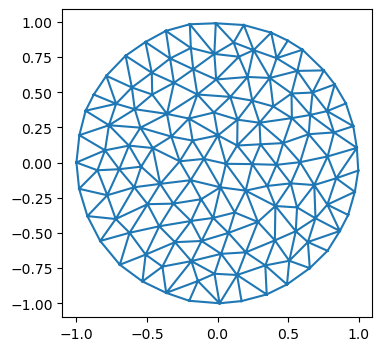

In [96]:
fig = plt.figure(figsize=(4, 4))
plt.triplot(*geommesh.vertices.T, mesh.faces)
plt.axis("equal");

In [98]:
lengths = jnp.linalg.norm(geommesh.vertices[hemesh.orig]-geommesh.vertices[hemesh.dest], axis=1)
tri_areas = -jax.vmap(get_polygon_area)(geommesh.vertices[hemesh.faces])

lengths.mean(), tri_areas.mean()

(Array(0.18296366, dtype=float64), Array(0.01391806, dtype=float64))

In [ ]:
# We write the energy_function using a geommesh as an argument. This is overkill for present purposes
# since only the vertex positions matter, but is useful to test the machinery. For more complicated 
# simulations, we will want to use GeomMesh as a wrapper for the various arrays.

#@functools.partial(jax.jit, static_argnames=['ell_0']) # this is how we would make an argument to be static
jax.jit
def energy_function(geommesh: GeomMesh, hemesh: HeMesh, ell_0: float=1):
    edge_lengths = jnp.linalg.norm(geommesh.vertices[hemesh.orig]-geommesh.vertices[hemesh.dest], axis=1)
    edge_energy = jnp.mean((edge_lengths/ell_0-1)**2) # this way, term is "auto-normalized"
    # let's add a term for the triangle areas
    a_0 = (np.sqrt(3)/4) * ell_0**2 # area of equilateral triangle
    tri_area = -jax.vmap(get_polygon_area)(geommesh.vertices[hemesh.faces])
    area_energy = jnp.mean((tri_area/a_0-1)**2)
    #jax.debug.print("E_l: {E_l}, E_a: {E_a}",  E_l=edge_energy, E_a=area_energy) # this is how you can print inside a JITed-function
    return edge_energy + area_energy


In [100]:
energy_function(geommesh, hemesh)

Array(1.60519339, dtype=float64)

In [101]:
# using functools.partial, we can fill in some of our function's args, like so:

functools.partial(energy_function, hemesh=hemesh, ell_0=1)(geommesh)

Array(1.60519339, dtype=float64)

In [102]:
val, grad = jax.value_and_grad(energy_function)(geommesh, hemesh) # computing value and grad works

val, grad, grad.vertices

(Array(1.60519339, dtype=float64),
 GeomMesh(N_V=131, N_HE=708, N_F=224),
 Array([[-7.57634982e-03,  9.70304611e-03],
        [ 3.20336353e-03, -6.36779182e-04],
        [-2.36642917e-03,  1.36356064e-03],
        [-6.93987668e-04, -2.22266491e-03],
        [-1.53260809e-03, -7.87905158e-05],
        [-1.12135842e-03, -7.10123175e-04],
        [ 7.39736557e-04,  8.84290064e-04],
        [-1.62673981e-03, -1.43147553e-04],
        [ 1.42871048e-03, -3.38338611e-03],
        [-8.59922907e-03, -9.09290491e-03],
        [-5.34972725e-03,  1.12288424e-02],
        [ 9.69308169e-04,  4.21637388e-03],
        [-5.86875983e-05,  1.07444457e-03],
        [ 6.76498061e-04,  1.25524788e-03],
        [-2.34484944e-03, -1.06454142e-03],
        [-4.36254915e-04,  7.52207848e-04],
        [-6.14352618e-04,  4.26557295e-04],
        [ 7.91994946e-04, -3.28598868e-03],
        [-3.19860985e-04,  2.27611173e-03],
        [-1.19471242e-03, -2.26498804e-03],
        [-4.02008378e-03, -6.79235170e-03],
  

In [103]:
connectivity_grad = jax.grad(energy_function, argnums=1, allow_int=True)(geommesh, hemesh)
# we can even compute the gradient w.r.t to the connectivity matrix. It is also a HeMesh
connectivity_grad, connectivity_grad.dest[0] # whatever that means

(HeMesh(N_V=131, N_HE=708, N_F=224), np.void((b'',), dtype=[('float0', 'V')]))

In [174]:
# let's do a simple optimization run

# parameters of the energy
ell_0 = 0.5

# parameters of the "optimizer"
step_size = 0.05
N_steps = 10000

@jax.jit
def make_step(geommesh: GeomMesh, hemesh: HeMesh, ell_0: float = 1, step_size: float = 0.01):
    loss, grad = jax.value_and_grad(energy_function)(geommesh, hemesh, ell_0=ell_0)

    # update - this can be streamlined in the future with equinox
    updated_vertices = geommesh.vertices - step_size*grad.vertices
    geommesh_updated = dataclasses.replace(geommesh, vertices=updated_vertices)
    return geommesh_updated, hemesh, loss # explicitly return the hemesh - in the future, it may need to be updated, e.g., by flips!

# define inital condition
geommesh_trained = copy.copy(geommesh)
hemesh_trained = copy.copy(hemesh)

losses = []

for step in range(N_steps):
    geommesh_trained, hemesh_trained, loss = make_step(geommesh_trained, hemesh_trained, ell_0=ell_0, step_size=step_size)
    losses.append(loss)

losses = np.array(losses)

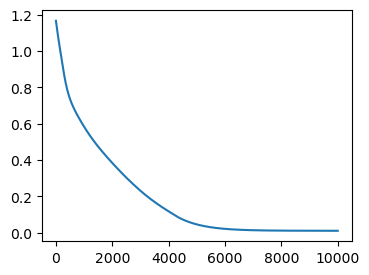

In [175]:
fig = plt.figure(figsize=(4, 3))
plt.plot(losses)

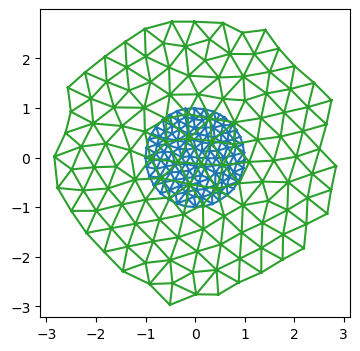

In [176]:
fig = plt.figure(figsize=(4, 4))

plt.triplot(*geommesh.vertices.T, hemesh.faces)

plt.triplot(*geommesh_trained.vertices.T, hemesh_trained.faces)

plt.axis("equal");

In [177]:
lengths_trained = jnp.linalg.norm(geommesh_trained.vertices[hemesh.orig]
                                  -geommesh_trained.vertices[hemesh.dest], axis=1)
jnp.abs(lengths_trained-ell_0).mean(), lengths_trained.mean()

(Array(0.03342644, dtype=float64), Array(0.50208086, dtype=float64))

### Meta-training

Eventually, we aim to learn some dynamical rules for a tissue mechanics model that make the tissue carry out some desired behavior, like making a target shape. As a toy example, let's take the above "dynamics" which minimizes the pseudo-energy to make all triangles equilateral. It depends on the parameter $\ell_0$. Relaxation of the pseudo-energy for some number of steps defines our "forward pass". Let's try to optimize $\ell_0$ so that the tissue, at the end of the energy relaxation, has some target size (of course, a contrived problem, since we know the solution from the start).

In [202]:
# package the whole training process into a JITed function

@functools.partial(jax.jit, static_argnames=['N_steps'])
def relax_energy(initial_geommesh: GeomMesh, initial_hemesh: HeMesh, ell_0: float = 1,
                 step_size: float = 0.01, N_steps: int = 1):

    # define initial condition
    geommesh_trained = copy.copy(initial_geommesh)
    hemesh_trained = copy.copy(initial_hemesh)

    # use a jax.lax.fori_loop loop for training. This leads to much faster JIT-compilation than a Python for loop.
    loss = 0
    init = (initial_geommesh, initial_hemesh, loss)
    loop_fun = lambda i, carry: make_step(carry[0], carry[1], ell_0=ell_0, step_size=step_size) 
    geommesh_trained, hemesh_trained, loss = jax.lax.fori_loop(0, N_steps, loop_fun, init, unroll=None)
    
    return (geommesh_trained, hemesh_trained), loss

In [227]:
(geommesh_trained, hemesh_trained), losses = relax_energy(geommesh, hemesh, ell_0=0.5, step_size=0.05, N_steps=5000)
losses

Array(0.04463656, dtype=float64)

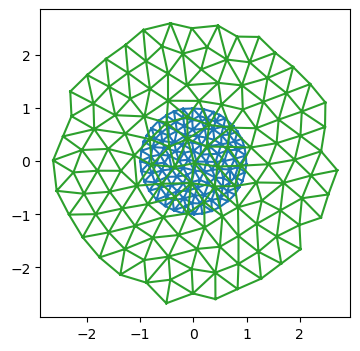

In [228]:
fig = plt.figure(figsize=(4, 4))
plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*geommesh_trained.vertices.T, hemesh_trained.faces)
plt.axis("equal");

In [223]:
%%timeit
_ = relax_energy(geommesh, hemesh, ell_0=0.5, step_size=0.05, N_steps=5000)

28.6 ms ± 250 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now we need to define our meta-training loss. In this case, it's just the deviation of the average edge length from the total.
Note how the meta-loss is _distinct_ from the pseudo-energy we minimize during the forward pass.

Let's use the `equinox` library to handle our problem, in anticipation of more complex ones down the line.

In [356]:
class RelaxationDynamics(eqx.Module): # we create a model that is simply our relaxational dynamics 
    ell_0: jax.Array
    step_size : float = eqx.field(static=True)
    N_steps : int = eqx.field(static=True)

    def __call__(self, initial_geommesh: GeomMesh, initial_hemesh: HeMesh) -> Tuple[GeomMesh, HeMesh]:
        init = (initial_geommesh, initial_hemesh, 0)
        loop_fun = lambda i, carry: make_step(carry[0], carry[1], ell_0=self.ell_0, step_size=self.step_size)
        geommesh_trained, hemesh_trained, loss = jax.lax.fori_loop(0, N_steps, loop_fun, init, unroll=None)
        return geommesh_trained, hemesh_trained

In [511]:
# define the meta-loss

meta_ell0 = 0.4

def meta_loss(model: RelaxationDynamics, initial_geommesh: GeomMesh, initial_hemesh: HeMesh,  meta_ell0: float) -> float:
    geommesh_trained, hemesh_trained = model(initial_geommesh, initial_hemesh)
    lengths = jnp.linalg.norm(geommesh_trained.vertices[hemesh_trained.orig]
                              -geommesh_trained.vertices[hemesh_trained.dest], axis=-1)
    return jnp.mean((lengths/meta_ell0-1)**2)

In [512]:
# initialize the model, and test evaluating it

step_size = 0.01
N_steps = 20000

initial_ell0 = 0.2

model_initial = RelaxationDynamics(ell_0=jnp.array([initial_ell0]), step_size=step_size, N_steps=N_steps)
model_initial(geommesh, hemesh), meta_loss(model_initial, geommesh, hemesh, meta_ell0=meta_ell0)

((GeomMesh(N_V=131, N_HE=708, N_F=224), HeMesh(N_V=131, N_HE=708, N_F=224)),
 Array(0.24848912, dtype=float64))

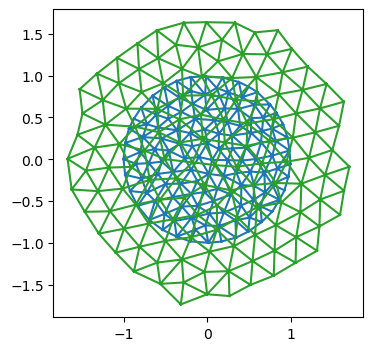

In [496]:
# let's check that the model still does what we want - looks good!
geommesh_trained, hemesh_trained = model_initial(geommesh, hemesh)

fig = plt.figure(figsize=(4, 4))
plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*geommesh_trained.vertices.T, hemesh_trained.faces)
plt.axis("equal");

#### Batching

To evaluate the loss, we probably want to average over a bunch of initial conditions. These are analogous to _batches_ in a normal ML problem.

In [563]:
## Let us create a bunch of meshes with different initial positions and see if we can batch over them using vmap

key = jax.random.key(0)
sigma = 0.02

batch_geom = []
batch_he = []
for i in range(3):
    key, subkey = jax.random.split(key)
    random_noise = jax.random.normal(subkey, shape=geommmesh.vertices.shape)
    batch_geom.append(dataclasses.replace(geommmesh, vertices=geommmesh.vertices+sigma*random_noise))
    batch_he.append(copy.copy(hemesh))

In [ ]:
# we use a jax.tree.map to "push" the list axis into the underlying arrays.

batch_he_array = tree_stack(batch_he)
batch_geom_array = tree_stack(batch_geom)
batch_geom_array, batch_geom_array.vertices.shape

(GeomMesh(N_V=131, N_HE=708, N_F=224), (3, 131, 2))

In [ ]:
# The result is a single mesh object with batch axes

batch_geom_array_out, batch_he_array_out = jax.vmap(model_initial)(batch_geom_array, batch_he_array) 
batch_geom_array_out, batch_geom_array_out.vertices.shape, batch_he_array_out.orig.shape

(GeomMesh(N_V=131, N_HE=708, N_F=224), (3, 131, 2), (3, 708))

In [412]:
# we can unpack things again into a list of meshes

batch_geom_out = tree_unstack(batch_geom_array_out)
batch_he_out = tree_unstack(batch_he_array_out)

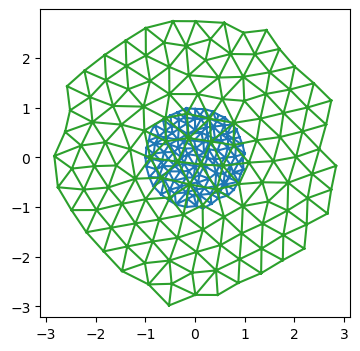

In [422]:
# still works

i = 2
fig = plt.figure(figsize=(4, 4))
plt.triplot(*batch_geom[i].vertices.T, batch_he[i].faces)
plt.triplot(*batch_geom_out[i].vertices.T, batch_he_out[i].faces)
plt.axis("equal");

In [374]:
# the batches are not identical, which is good.
np.allclose(batch_geom_out[0].vertices, batch_geom_out[1].vertices)

False

In [445]:
# now let's compute the batched loss

In [446]:
delta = batch_geom_array_out.vertices[batch_he_array_out.orig]-batch_geom_array_out.vertices[batch_he_array_out.dest]
delta.shape # looks like the shape of the vertex-vertex distance vector (in the vectorized version) is not correct. Problem for loss.

(3, 708, 131, 2)

In [448]:
meta_loss(jax.vmap(model_initial), batch_geom_array, batch_he_array, meta_ell0=0.5) # so this is incorrect

Array(0.24966711, dtype=float64)

In [449]:
jax.vmap(meta_loss, in_axes=(None, 0,0, None))(model_initial, batch_geom_array, batch_he_array, 0.8) # but this is right

Array([0.09065948, 0.09064973, 0.09063513], dtype=float64)

In [451]:
# pretty similar, floating point errors likely at origin of differences
[meta_loss(model_initial, batch_geom_out[i], batch_he_out[i], 0.8) for i in range(3)] 

[Array(0.08987257, dtype=float64),
 Array(0.08986823, dtype=float64),
 Array(0.0898693, dtype=float64)]

#### Outer optimization

Based on [equinox CNN tutorial](https://docs.kidger.site/equinox/examples/mnist/#training).

In [772]:
def batched_meta_loss(model, batch_geom_array, batch_he_array, meta_ell0):
    return jnp.mean(jax.vmap(meta_loss, in_axes=(None, 0,0, None))(model, batch_geom_array, batch_he_array, meta_ell0))

batched_meta_loss_jit = jax.jit(batched_meta_loss)

In [773]:
#| notest

## Let's do a short profiling run - how much does JIT-compilation save? I guess a little!
%timeit batched_meta_loss_jit(model_initial, batch_geom_array, batch_he_array, META_ELL0).block_until_ready()

363 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [774]:
#| notest

%timeit batched_meta_loss(model_initial, batch_geom_array, batch_he_array, META_ELL0).block_until_ready()

452 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [718]:
# hyper-parameters for the outer learning step.

BATCH_SIZE = 3
LEARNING_RATE = 1e-2
LEARNING_STEPS = 20
print_every = 2

step_size = 0.01
N_steps = 20000

META_ELL0 = 0.4
initial_ell0 = 0.2

model_initial = RelaxationDynamics(ell_0=jnp.array([initial_ell0]), step_size=step_size, N_steps=N_steps)

In [616]:
loss, grads = eqx.filter_value_and_grad(batched_meta_loss)(model_initial, batch_geom_array, batch_he_array, META_ELL0)
loss, grads.ell_0

(Array(0.24848912, dtype=float64), Array([-2.48069192], dtype=float64))

In [691]:
get_grad = eqx.filter_jit(eqx.filter_value_and_grad(batched_meta_loss))
#get_grad = eqx.filter_value_and_grad(batched_meta_loss)

In [692]:
get_grad(model_initial, batch_geom_array, batch_he_array, META_ELL0)

(Array(0.24848912, dtype=float64),
 RelaxationDynamics(ell_0=f64[1], step_size=0.01, N_steps=20000))

In [782]:
@eqx.filter_jit
def outer_optimizer_step(model: RelaxationDynamics,
                         batch_geom: GeomMesh, batch_he: HeMesh) -> Tuple[RelaxationDynamics, float]:
    
    # compute loss and grad on batch
    #loss, grads = eqx.filter_value_and_grad(batched_meta_loss)(model, batch_geom_array, batch_he_array, META_ELL0)
    #updates = jax.tree.map(lambda g: None if g is None else -LEARNING_RATE * g, grads)
    #model = eqx.apply_updates(model, updates)
    # grads is a PyTree with the same leaves as the trainable arrays of the model

    # same story, but using forward mode autodiff
    loss, grads = eqx.filter_jvp(lambda model: batched_meta_loss(model, batch_geom_array, batch_he_array, META_ELL0),
                                 primals=[model,], tangents=[model,])
    grads = grads/model.ell_0 # we used the current model values as a tangent vector, so we need to normalize
    model = dataclasses.replace(model, ell_0=model.ell_0-LEARNING_RATE*grads)
    
    return model, loss

In [783]:
model_stepped, loss = outer_optimizer_step(model_initial, batch_geom_array, batch_he_array)

In [784]:
loss, model_initial.ell_0, model_stepped.ell_0

(Array(0.24848912, dtype=float64),
 Array([0.2], dtype=float64),
 Array([0.22480692], dtype=float64))

In [786]:
#| notest

model = model_initial

for step in tqdm(range(LEARNING_STEPS)): # in the future, could also iterate over the initial conditions/batches
    model, loss = outer_optimizer_step(model, batch_geom_array, batch_he_array)
    if (step % print_every) == 0:
        print(f"Step: {step}, loss: {loss}, param: {model.ell_0}")

# 19s with forward mode vs 32s with reverse mode

  0%|          | 0/20 [00:00<?, ?it/s]

Step: 0, loss: 0.24848912252997113, param: [0.22480692]
Step: 2, loss: 0.14705089085892747, param: [0.26531753]
Step: 4, loss: 0.08837979899550398, param: [0.2961096]
Step: 6, loss: 0.054585401871955354, param: [0.31944911]
Step: 8, loss: 0.03523557387981517, param: [0.33709801]
Step: 10, loss: 0.02416287104694408, param: [0.35046337]
Step: 12, loss: 0.017773306855439645, param: [0.36064458]
Step: 14, loss: 0.014026882067898084, param: [0.36847044]
Step: 16, loss: 0.011786332957303053, param: [0.37454737]
Step: 18, loss: 0.010418687013418974, param: [0.37931378]
CPU times: user 23.1 s, sys: 1.37 s, total: 24.5 s
Wall time: 19 s


### Success!

We can solve this (stupid) toy problem - our JAX-compatible infrastructure for vertex models seems to work.
Next step: 

1. Toy simulations with T1s
2. More complex models - say, the area-perimeter vertex model
3. Play around with neural ODEs and neural optimizers more generally.


